In [2]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import csv
data = []
with open("cleaned/FL.csv", "r", encoding="utf-8") as f:
    csv_reader = csv.reader(f, delimiter=',')
    headers = next(csv_reader)
    for i in csv_reader:
        data.append(int(i[5]))

train  = data[:-300]
test = data[-300:]

li_x = []
li_y = []
seq = 2

# 因为数据集较少，序列长度太长会影响结果
for i in range(len(data[:-300]) - seq):
    # 输入就是[x,x+1]天的数据，输出时x+2天的数据
    li_x.append(train[i: i+seq])
    li_y.append(train[i+seq])

t_x = []
t_y = []
# 因为数据集较少，序列长度太长会影响结果
for i in range(len(data[-300:]) - seq):
    # 输入就是[x,x+1]天的数据，输出时x+2天的数据*
    t_x.append(test[i: i+seq])
    t_y.append(test[i+seq])

# print(li_x)
# print(li_y)

# 分训练和测试集
train_x = (torch.tensor(li_x).float() / 1000.).reshape(-1, seq, 1).to(device)
train_y = (torch.tensor(li_y).float() / 1000.).reshape(-1, 1).to(device)

print(train_x.shape)

test_x = (torch.tensor(t_x).float() / 1000.).reshape(-1, seq, 1).to(device)
test_y = (torch.tensor(t_y).float() / 1000.).reshape(-1, 1).to(device)

torch.Size([439, 2, 1])


In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=32, num_layers=1, batch_first=True)
        # 输入格式是1，输出隐藏层大小是32
        # 对于小数据集num_layers不要设置大，否则会因为模型变复杂而导致效果会变差
        # num_layers顾名思义就是有几个lstm层，假如设置成2，就相当于连续经过两个lstm层
        # 原来的输入格式是：(seq, batch, shape)
        # 设置batch_first=True以后，输入格式就可以改为：(batch, seq, shape)，更符合平常使用的习惯
        self.linear = nn.Linear(32*seq, 1)

    def forward(self, x):
        x, (h, c) = self.lstm(x)
        x = x.reshape(-1, 32*seq)
        x = self.linear(x)
        return x

In [6]:
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
loss_fun = nn.MSELoss()

In [7]:
model.train()
for epoch in range(1500):
    output = model(train_x)
    loss = loss_fun(output, train_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0 and epoch > 0:
        test_loss = loss_fun(model(test_x), test_y)
        print("epoch:{}, loss:{}, test_loss: {}".format(epoch, loss, test_loss))

epoch:20, loss:27.24819564819336, test_loss: 330.5658874511719
epoch:40, loss:11.607481002807617, test_loss: 269.5300598144531
epoch:60, loss:5.643003940582275, test_loss: 223.1072540283203
epoch:80, loss:3.691063165664673, test_loss: 204.99209594726562
epoch:100, loss:2.9300692081451416, test_loss: 192.343505859375
epoch:120, loss:2.5241482257843018, test_loss: 183.3928985595703
epoch:140, loss:2.327524423599243, test_loss: 176.856201171875
epoch:160, loss:2.248695135116577, test_loss: 172.2076873779297
epoch:180, loss:2.209228515625, test_loss: 168.99447631835938
epoch:200, loss:2.182936668395996, test_loss: 166.6190948486328
epoch:220, loss:2.16255521774292, test_loss: 164.70941162109375
epoch:240, loss:2.1448161602020264, test_loss: 163.0875244140625
epoch:260, loss:2.1283926963806152, test_loss: 161.65020751953125
epoch:280, loss:2.112856149673462, test_loss: 160.3340606689453
epoch:300, loss:2.0981545448303223, test_loss: 159.11695861816406
epoch:320, loss:2.083888053894043, test

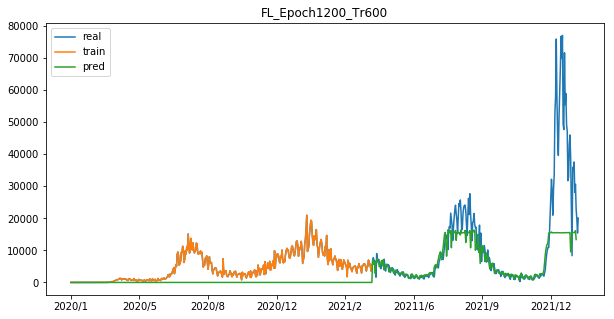

In [8]:
model.eval()
# result = li_x[0][:seq-1] + list((model(train_x).data.reshape(-1))*1000) + list((model(test_x).data.reshape(-1))*1000)
result = [0] + list((model(train_x).data.reshape(-1))*00) + list((model(test_x).data.reshape(-1))*1000)

#展示结果
plt.figure(figsize=(10,5))

plt.plot(data,label="real")
# 原来的走势

plt.plot(train,label="train")

plt.plot(result,label="pred")
plt.xticks(
    [0,100,200,300,400,500,600,700],
    ['2020/1','2020/5', '2020/8', '2020/12', '2021/2', '20211/6', '2021/9', '2021/12']
)
# 模型预测的走势
plt.legend(loc='best')
plt.title('FL_Epoch1200_Tr600')
# plt.savefig('plot/FL_Epoch1200_Tr600.jpg')
plt.show()

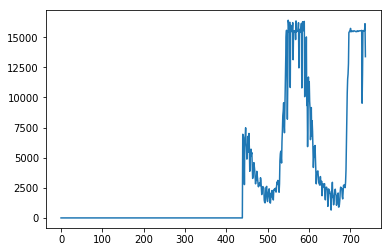

In [9]:
plt.plot(result)

In [10]:
# prediction = result[200:700]
# real = data[200:700]

# from sklearn.metrics import mean_squared_error
# MSE = mean_squared_error(real, prediction)
# RMSE = MSE ** 0.5
# print("MSE:", MSE)
# print("RMSE", RMSE)

                  MSE         RMSE
200:300  4.513040e+06  2124.391751
300:400  9.345359e+06  3057.017989
400:500  2.125294e+06  1457.838872
500:600  3.761253e+07  6132.905443
600:700  2.556825e+06  1599.007396


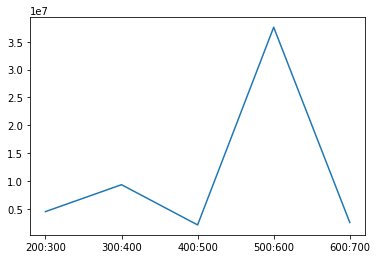

In [11]:
#Tr Size: 200 days
import pandas as pd
info = ['200:300', '300:400', '400:500', '500:600', '600:700']
MSE_list = [4513040.31369507, 9345358.983941305, 2125294.17701694, 37612529.172058195, 2556824.651083408]
RMSE_list = [2124.3917514655977, 3057.0179888154576, 1457.8388721038207, 6132.905442941233, 1599.0073955687035]

DF = pd.DataFrame({'MSE': MSE_list, 'RMSE': RMSE_list}, index=info)
print(DF)
plt.plot(DF.MSE)

In [12]:
DF

,MSE,RMSE
200:300,4.513040e+06,2124.391751
300:400,9.345359e+06,3057.017989
400:500,2.125294e+06,1457.838872
500:600,3.761253e+07,6132.905443
600:700,2.556825e+06,1599.007396


In [13]:
#Tr Size: 300 days
info = ['300:400', '400:500', '500:600', '600:700']
MSE_list = [15859510.681514425, 3086902.190155774, 42523704.73638685, 3529988.249845526]
RMSE_list = [3982.4001156983745, 1756.958220947719, 6521.02022205014, 1878.8262958148969]

In [14]:
#Tr Size: 400 days
info = ['400:500', '500:600', '600:700']
MSE_list = [4338729.452249858, 38993566.927481525, 3568011.513790344]
RMSE_list = [2082.9617020602795, 6244.4829191440285, 1888.9180802222058]

In [15]:
#Tr Size: 500 days
info = ['500:600', '600:700']
MSE_list = [29760939.82130769, 2635325.4543793853]
RMSE_list = [5455.358816916417, 1623.3685516170951]

In [17]:
from sklearn.metrics import mean_squared_error
temp_MSE = []
temp_RMSE = []
for i in range(500,700,100):
    MSE = mean_squared_error(result[i:i+100], data[i:i+100])
    temp_MSE.append(MSE)
    RMSE = MSE ** 0.5
    temp_RMSE.append(RMSE)
print(temp_MSE)
print(temp_RMSE)

[19215139.72179888, 2048266.8634953543]
[4383.50769610353, 1431.176740830899]


C:\Users\goodr\anaconda3\envs\mll\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
C:\Users\goodr\anaconda3\envs\mll\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
